**Goal**: In this notebook, we show how to solve the component identifiability problem.

We will train an unsupervised model to analyze handwritten digits numbered from zero to ten. Specifically, we will use non-negative matrix factorization (NMF) to extract recurring patterns in the digits. To verify if the extracted patterns are robust, you can run the model a couple of times to see if similar patterns emerge each time.
However, even if the patterns are robust, the components will vary from run to run. This is because the model is symmetric under permutation of the component index. This is called the **identifiability problem**. We will show how this can be solved using the `cluster_latent_components` function.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.decomposition import NMF
from toplot.algorithms import cluster_latent_components, invert_cluster_mapping

Each image is a grayscale image of 8-by-8 pixels. For example, the first image in the dataset is a zero:

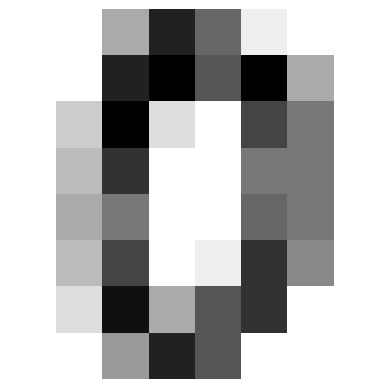

In [2]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X_train = digits.images.reshape((n_samples, -1))
plt.imshow(X_train[0].reshape(8, 8), cmap=plt.cm.gray_r, interpolation="nearest")
plt.gca().set_axis_off()

Non-negative matrix factorization tries to find  the weights $\pmb{W}$ and hidden units $\pmb{H}=[\pmb{h}^{(1)}, \dots, \pmb{h}^{(m)}]^T$ such that $\pmb{x}^{(i)} \approx \pmb{h}^{(i)} \pmb{W}$. 
Before training, the weights $\pmb{W}$ and hidden units $\pmb{H}$ of the model are initialized randomly. As a result, for each different starting point the model will converge to a different solution.

To show this, we will train three identical models:

In [3]:
settings = {"init": "random", "n_components": 10, "tol": 1e-6, "max_iter": 1000}
model1 = NMF(**settings).fit(X_train)
model2 = NMF(**settings).fit(X_train)
model3 = NMF(**settings).fit(X_train)
models = [model1, model2, model3]

Look at the weights $\pmb{W}$ (=`model.components_`) of the model, you can see that similar patterns are identified. However, these patterns are assigned to different components.

<Figure size 640x480 with 0 Axes>

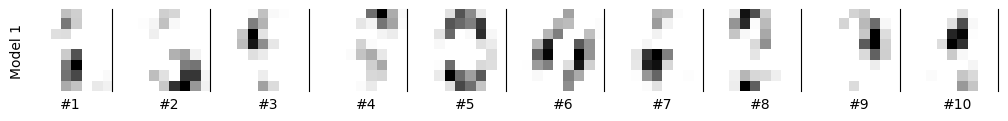

<Figure size 640x480 with 0 Axes>

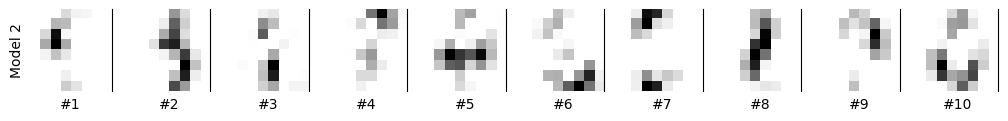

<Figure size 640x480 with 0 Axes>

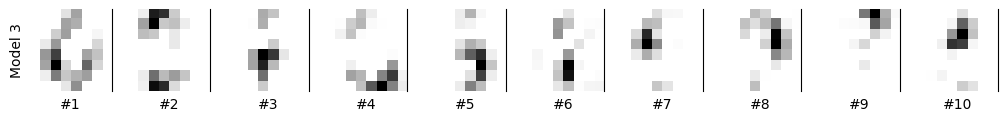

In [5]:
def plot_digit(x_digit, ax):
    ax.imshow(x_digit.reshape(8, 8), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)


weights = [m.components_ for m in models]

for i in range(len(models)):  # For each model solution.
    plt.figure()
    _, axes = plt.subplots(nrows=1, ncols=10, figsize=(12.5, 6))
    axes[0].set_ylabel("Model {}".format(i + 1))
    for k, (ax, weight_k) in enumerate(zip(axes.flatten(), weights[i])):
        plot_digit(weight_k, ax)
        ax.set_xlabel(f"#{k+1}")

These components can be reidentified using the function `cluster_latent_components`. We will use Euclidean distance as a measure of "closeness" between the weights. But we could also use other metrics like cosine distance, or if your weights are probabilities, Jensen-Shannon.

In [6]:
cluster_identities, centroids = cluster_latent_components(
    weights[0], weights[1], weights[2], metric="euclidean"
)
cluster_identities

array([[2, 5, 0, 3, 9, 1, 4, 6, 8, 7],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [9, 6, 4, 5, 1, 2, 0, 8, 3, 7]])

We can now sort the topics by inverting the mapping.

<Figure size 640x480 with 0 Axes>

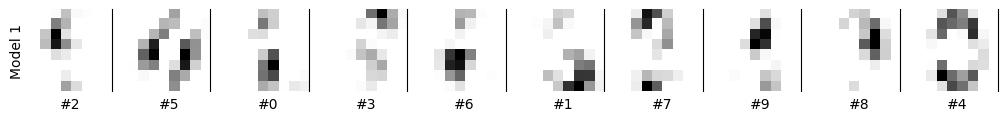

<Figure size 640x480 with 0 Axes>

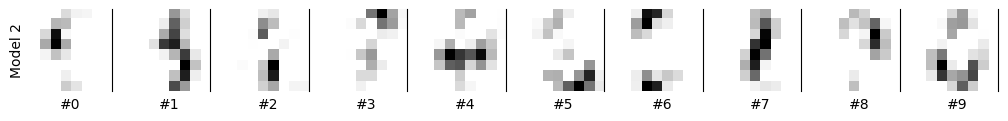

<Figure size 640x480 with 0 Axes>

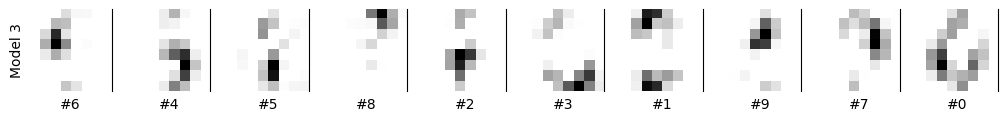

In [8]:
cluster_itentities_inv = invert_cluster_mapping(cluster_identities)
for i in range(len(models)):  # For each model solution.
    plt.figure()
    _, axes = plt.subplots(nrows=1, ncols=10, figsize=(12.5, 6))
    axes[0].set_ylabel("Model {}".format(i + 1))
    for k, ax in enumerate(axes.flatten()):
        c = cluster_itentities_inv[i, k]
        plot_digit(weights[i][c], ax)
        ax.set_xlabel(f"#{c}")